# Avaliando o uso do TPOT em um caso simples de regressão

O *TPOT* é uma biblioteca de AUTOML baseada principalmente no scikit-learn. Ele é treinado utilizando um algoritmo de programação genética, o que garante que diversos modelos com diversos parâmetros diferentes sejam treinados por diversas gerações até encontrar o modelo ótimo, isso é, aquele que seja menos complexo e possua a maior métrica de avaliação. Sua proposta é para que ele seja uma espécie de *assistente do cientista de dados*, automatizando processos repetitivos para que a performance analítica do profissional seja melhor aproveitada.
Um artigo de 2016 sobre como essa biblioteca funciona e sua aplicação na área da biomedicina pode ser encontrado nesse [link](https://link.springer.com/chapter/10.1007/978-3-319-31204-0_9).

Para essa análise foi utilizado um dataset disponibilizado no kaggle: [Dataset](https://www.kaggle.com/datasets/rkiattisak/student-performance-in-mathematics?resource=download)

O dataset nesse teste em questão tem o objetivo de prever a pontuação de alunos em determinadas provas a partir de seus atributos demográficos como genêro, educação dos pais, etc.
Como se trata apenas de um teste, as previsões serão apenas das pontuações no teste de matemática, nomeada na tabela como `math score`

Os atributos presentes no dataset são:
`gender`, `race/ethnicity`, `parental level of education`, `lunch`, `test preparation course`

Para fins de comparação além do modelo generado pelo *TPOT*, também foi treinado um modelo utilizando `SGDRegressor`

In [1]:
import numpy as np
import pandas as pd
from sklearn import set_config

set_config(display="diagram")

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv("exams.csv")
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group D,some college,standard,completed,59,70,78
1,male,group D,associate's degree,standard,none,96,93,87
2,female,group D,some college,free/reduced,none,57,76,77
3,male,group B,some college,free/reduced,none,70,70,63
4,female,group D,associate's degree,standard,none,83,85,86


In [4]:
df["race/ethnicity"].value_counts()

race/ethnicity
group C    323
group D    257
group B    198
group E    143
group A     79
Name: count, dtype: int64

In [5]:
df["parental level of education"].value_counts()

parental level of education
some college          224
high school           215
associate's degree    204
some high school      177
bachelor's degree     105
master's degree        75
Name: count, dtype: int64

In [6]:
df["lunch"].value_counts()

lunch
standard        660
free/reduced    340
Name: count, dtype: int64

In [ ]:
df["test preparation course"].value_counts()

test preparation course
none         656
completed    344
Name: count, dtype: int64

### Todas as categorias foram *encodadas* para que se adequassem aos métodos de treinamento

In [8]:
# df["gender_encoded"] = df["gender"].map({"male": 1, "female": 0})
# df["race_encoded"] = df["race/ethnicity"].map(
#     {"group A": 4, "group B": 3, "group C": 2, "group D": 1, "group E": 0}
# )
# df["parent_encoded"] = df["parental level of education"].map(
#     {
#         "some high school": 1,
#         "high school": 2,
#         "associate's degree": 3,
#         "some college": 4,
#         "bachelor's degree": 5,
#         "master's degree": 6,
#     }
# )
# df["lunch_encoded"] = df["lunch"].map({"standard": 0, "free/reduced": 1})
# df["prep_encoded"] = df["test preparation course"].map({"none": 0, "completed": 1})
# df.head()

In [9]:
X = df.drop(
    [
        "math score",
        "reading score",
        "writing score",
        "gender",
        "race/ethnicity",
        "parental level of education",
        "lunch",
        "test preparation course",
    ],
    axis=1,
)
y = df["math score"]

print(X.shape, y.shape)

(1000, 0) (1000,)


In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from autogluon.tabular import TabularDataset, TabularPredictor

# --- 1. Carregar Dados (Titanic) ---
url = "https://autogluon.s3.amazonaws.com/datasets/titanic/train.csv"
df = pd.read_csv(url)

# Defina a coluna alvo para o Titanic
LABEL = "Survived"

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [32]:
df["PassengerId"] = df["PassengerId"].astype("object")
df.drop(["PassengerId", "Name"], axis=1, inplace=True)

In [46]:
# --- 2. O PULO DO GATO: train_test_split ---
# O Titanic é um problema de classificação binária (0 ou 1)
train_data, test_data = train_test_split(
    df, test_size=0.25, random_state=42, stratify=df[LABEL]
)

print(f"Linhas para Treino: {len(train_data)}")
print(f"Linhas para Teste (Hold-out): {len(test_data)}")

# --- 3. Treinar ---
# Mudamos o problem_type para 'binary' e a métrica para 'accuracy'
predictor = TabularPredictor(label=LABEL, problem_type="binary", eval_metric="f1").fit(
    train_data,
    presets="best_quality",
    time_limit=60,
)

# --- 4. Avaliar ---
print("\n--- Avaliação Final (Dados nunca vistos) ---")
performance = predictor.evaluate(test_data)

# No Titanic, o resultado será a Acurácia (0 a 1). Quanto mais perto de 1, melhor.
print(performance)

# --- 5. BÔNUS: Ver Engenharia de Atributos ---
# Como você perguntou antes, aqui você confirma o que o AutoGluon fez:
print("\n--- Metadados das Features (Engenharia de Dados) ---")
print(predictor.feature_metadata)

No path specified. Models will be saved in: "AutogluonModels/ag-20260212_074135"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.10.19
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 25.2.0: Tue Nov 18 21:08:48 PST 2025; root:xnu-12377.61.12~1/RELEASE_ARM64_T8132
CPU Count:          10
Pytorch Version:    2.9.1
CUDA Version:       CUDA is not available
GPU Count:          WARNING: Exception was raised when calculating GPU count (AssertionError)
Memory Avail:       5.14 GB / 16.00 GB (32.1%)
Disk Space Avail:   379.74 GB / 460.43 GB (82.5%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyS

Linhas para Treino: 668
Linhas para Teste (Hold-out): 223


	Available Memory:                    5254.26 MB
	Train Data (Original)  Memory Usage: 0.15 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 1 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', [])  : 2 | ['Age', 'Fare']
		('int', [])    : 3 | ['Pclass', 'SibSp', 'Parch']
		('object', []) : 4 | ['Sex', 'Ticket', 'Cabin', 'Embarked']
	Types of features in processed data (raw dtype


--- Avaliação Final (Dados nunca vistos) ---
{'f1': 0.7236842105263158, 'accuracy': 0.8116591928251121, 'balanced_accuracy': np.float64(0.7796214564590053), 'mcc': 0.596332122972994, 'roc_auc': np.float64(0.8579612968935663), 'precision': 0.8333333333333334, 'recall': 0.6395348837209303}

--- Metadados das Features (Engenharia de Dados) ---
('category', [])  : 3 | ['Ticket', 'Cabin', 'Embarked']
('float', [])     : 2 | ['Age', 'Fare']
('int', [])       : 3 | ['Pclass', 'SibSp', 'Parch']
('int', ['bool']) : 1 | ['Sex']


In [48]:
# Gera o ranking detalhado usando os dados de teste (que o modelo não viu)
leaderboard = predictor.leaderboard(test_data, silent=True)

# Mostra as colunas mais importantes
print(leaderboard[["model", "score_test", "score_val", "pred_time_test"]].head(10))

                     model  score_test  score_val  pred_time_test
0          CatBoost_BAG_L1    0.754717   0.783505        0.012846
1        LightGBMXT_BAG_L1    0.727273   0.775100        0.026493
2      WeightedEnsemble_L2    0.723684   0.817021        0.075564
3    NeuralNetTorch_BAG_L1    0.711864   0.790323        0.052920
4   NeuralNetFastAI_BAG_L1    0.701987   0.814499        0.061687
5  RandomForestEntr_BAG_L1    0.691358   0.769539        0.034496
6           XGBoost_BAG_L1    0.688312   0.797521        0.045117
7          LightGBM_BAG_L1    0.687898   0.800821        0.021354
8    ExtraTreesGini_BAG_L1    0.678788   0.759596        0.032844
9    ExtraTreesEntr_BAG_L1    0.670732   0.761341        0.035309


In [49]:
# Isso mostra como ele transformou cada coluna bruta em colunas prontas para o modelo
print(predictor.leaderboard(test_data, extra_info=True))

# E para ver a importância (quem ele selecionou como "o time principal")
print(predictor.feature_importance(test_data))

Computing feature importance via permutation shuffling for 9 features using 223 rows with 5 shuffle sets...
	3.96s	= Expected runtime (0.79s per shuffle set)


                      model  score_test  score_val eval_metric  \
0           CatBoost_BAG_L1    0.754717   0.783505          f1   
1         LightGBMXT_BAG_L1    0.727273   0.775100          f1   
2       WeightedEnsemble_L2    0.723684   0.817021          f1   
3     NeuralNetTorch_BAG_L1    0.711864   0.790323          f1   
4    NeuralNetFastAI_BAG_L1    0.701987   0.814499          f1   
5   RandomForestEntr_BAG_L1    0.691358   0.769539          f1   
6            XGBoost_BAG_L1    0.688312   0.797521          f1   
7           LightGBM_BAG_L1    0.687898   0.800821          f1   
8     ExtraTreesGini_BAG_L1    0.678788   0.759596          f1   
9     ExtraTreesEntr_BAG_L1    0.670732   0.761341          f1   
10  RandomForestGini_BAG_L1    0.666667   0.772000          f1   

    pred_time_test  pred_time_val   fit_time  pred_time_test_marginal  \
0         0.013698       0.025917   6.506181                 0.013698   
1         0.025312       0.038176   2.996349                 

	1.02s	= Actual runtime (Completed 5 of 5 shuffle sets)


          importance    stddev   p_value  n  p99_high   p99_low
Sex         0.297189  0.068339  0.000313  5  0.437899  0.156479
Pclass      0.073019  0.017345  0.000355  5  0.108733  0.037305
Age         0.031999  0.043978  0.089535  5  0.122550 -0.058552
Embarked    0.027339  0.008130  0.000837  5  0.044079  0.010599
Ticket      0.027086  0.010989  0.002644  5  0.049714  0.004459
SibSp       0.014590  0.015272  0.049754  5  0.046036 -0.016855
Fare        0.009697  0.009381  0.040952  5  0.029013 -0.009618
Cabin       0.004996  0.010206  0.167612  5  0.026010 -0.016019
Parch       0.000132  0.017493  0.493658  5  0.036152 -0.035887


In [50]:
# Mostra quais transformações foram aplicadas e o tipo final de cada coluna
print(predictor.feature_metadata)

('category', [])  : 3 | ['Ticket', 'Cabin', 'Embarked']
('float', [])     : 2 | ['Age', 'Fare']
('int', [])       : 3 | ['Pclass', 'SibSp', 'Parch']
('int', ['bool']) : 1 | ['Sex']


In [43]:
df.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked'],
      dtype='object')

In [51]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val eval_metric  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       WeightedEnsemble_L2   0.817021          f1       0.109167  11.958994                0.002095           0.247257            2       True         11
1    NeuralNetFastAI_BAG_L1   0.814499          f1       0.081155   5.205556                0.081155           5.205556            1       True          8
2           LightGBM_BAG_L1   0.800821          f1       0.034742   2.964862                0.034742           2.964862            1       True          2
3            XGBoost_BAG_L1   0.797521          f1       0.042706   3.457174                0.042706           3.457174            1       True          9
4     NeuralNetTorch_BAG_L1   0.790323          f1       0.112309   8.852755                0.112309           8.852755            1       True         10
5       

/Users/gabrielsales/Documents/Projetos/tpot_examspred/.venv/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestGini_BAG_L1': 'StackerEnsembleModel_RF',
  'RandomForestEntr_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesGini_BAG_L1': 'StackerEnsembleModel_XT',
  'ExtraTreesEntr_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'LightGBMXT_BAG_L1': 0.7751004016064257,
  'LightGBM_BAG_L1': 0.8008213552361396,
  'RandomForestGini_BAG_L1': 0.772,
  'RandomForestEntr_BAG_L1': 0.7695390781563126,
  'CatBoost_BAG_L1': 0.7835051546391752,
  'ExtraTreesGini_BAG_L1': 0.7595959595959596,
  'ExtraTreesEntr_BAG_L1': 0.7613412228796844,
  'NeuralNetFastAI_BAG_L1': 0.814498933901

<Figure size 1000x800 with 0 Axes>

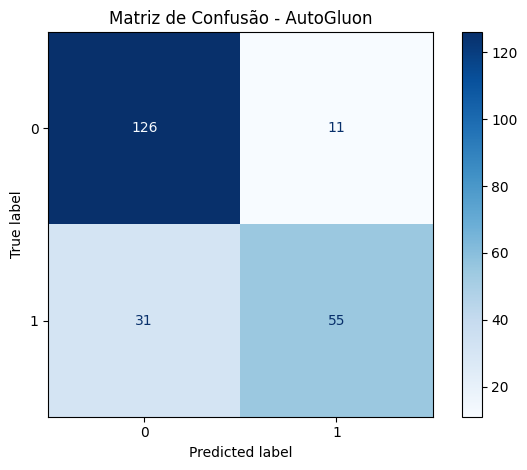

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Obter as previsões
y_true = test_data[LABEL]
y_pred = predictor.predict(test_data)

# 2. Criar a matriz
cm = confusion_matrix(y_true, y_pred)

# 3. Plotar de forma bonita
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=predictor.class_labels
)
disp.plot(cmap="Blues", values_format="d")
plt.title("Matriz de Confusão - AutoGluon")
plt.tight_layout()

plt.show()

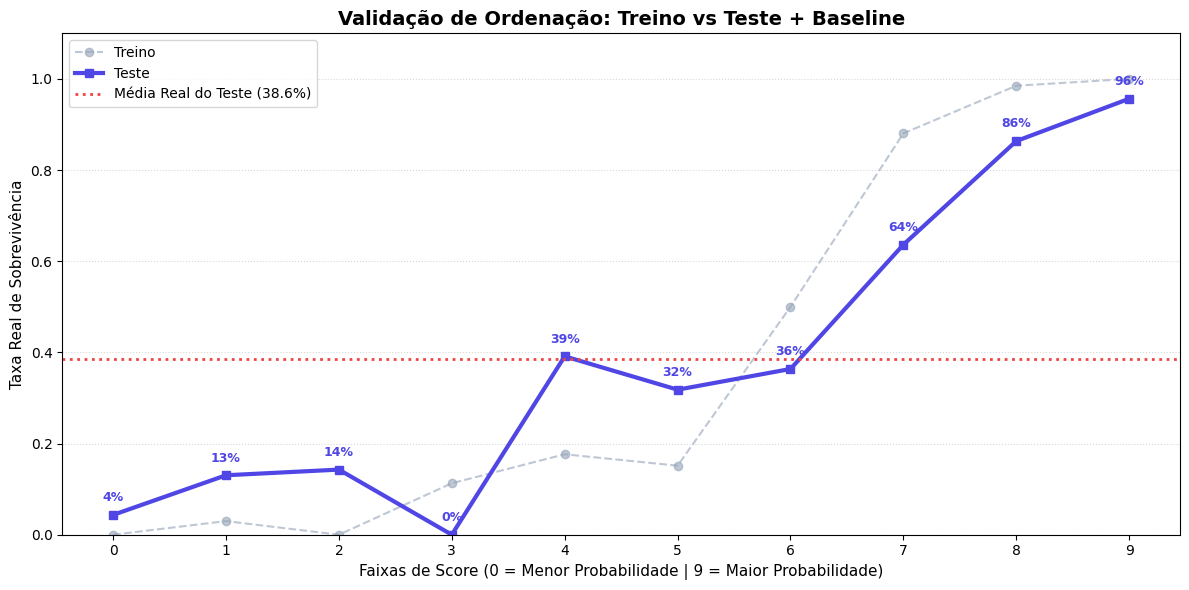

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


def plot_ordenacao_completa(predictor, train_data, test_data, label):
    # 1. Calculando scores para Treino e Teste
    probs_train = predictor.predict_proba(train_data)[1]
    probs_test = predictor.predict_proba(test_data)[1]

    # 2. Criando DataFrames auxiliares
    df_train = pd.DataFrame({"Real": train_data[label], "Score": probs_train})
    df_test = pd.DataFrame({"Real": test_data[label], "Score": probs_test})

    # 3. Criando os Decis (0 a 9) da esquerda para a direita
    df_train["Decil"] = pd.qcut(df_train["Score"], 10, labels=False, duplicates="drop")
    df_test["Decil"] = pd.qcut(df_test["Score"], 10, labels=False, duplicates="drop")

    # 4. Médias por Decil
    rank_train = df_train.groupby("Decil")["Real"].mean().sort_index()
    rank_test = df_test.groupby("Decil")["Real"].mean().sort_index()

    # 5. CÁLCULO DA MÉDIA GLOBAL (A linha de referência)
    media_global = test_data[label].mean()

    # 6. Plotagem
    plt.figure(figsize=(12, 6))

    # Linha do Treino (Cinza)
    plt.plot(
        rank_train.index.astype(str),
        rank_train.values,
        marker="o",
        linestyle="--",
        color="#94a3b8",
        label="Treino",
        alpha=0.6,
    )

    # Linha do Teste (Azul)
    plt.plot(
        rank_test.index.astype(str),
        rank_test.values,
        marker="s",
        linestyle="-",
        color="#4f46e5",
        label="Teste",
        linewidth=3,
    )

    # LINHA DA MÉDIA (Vermelha Pontilhada)
    plt.axhline(
        y=media_global,
        color="#ef4444",
        linestyle=":",
        linewidth=2,
        label=f"Média Real do Teste ({media_global:.1%})",
    )

    # Estética de Analista
    plt.title(
        "Validação de Ordenação: Treino vs Teste + Baseline",
        fontsize=14,
        fontweight="bold",
    )
    plt.xlabel(
        "Faixas de Score (0 = Menor Probabilidade | 9 = Maior Probabilidade)",
        fontsize=11,
    )
    plt.ylabel("Taxa Real de Sobrevivência", fontsize=11)
    plt.ylim(0, 1.1)
    plt.legend(loc="upper left")
    plt.grid(axis="y", linestyle=":", alpha=0.5)

    # Rótulos de dados apenas na linha de Teste
    for i, val in enumerate(rank_test.values):
        plt.text(
            i,
            val + 0.03,
            f"{val:.0%}",
            ha="center",
            fontsize=9,
            color="#4f46e5",
            fontweight="bold",
        )

    plt.tight_layout()
    plt.show()


# Rodar a função
plot_ordenacao_completa(predictor, train_data, test_data, LABEL)

   PassengerId  Survived  Pclass                            Name   Sex   Age  \
0            1         0       3         Braund, Mr. Owen Harris  male  22.0   
4            5         0       3        Allen, Mr. William Henry  male  35.0   
5            6         0       3                Moran, Mr. James  male   NaN   
6            7         0       1         McCarthy, Mr. Timothy J  male  54.0   
7            8         0       3  Palsson, Master. Gosta Leonard  male   2.0   

   SibSp  Parch     Ticket     Fare Cabin Embarked  
0      1      0  A/5 21171   7.2500   NaN        S  
4      0      0     373450   8.0500   NaN        S  
5      0      0     330877   8.4583   NaN        Q  
6      0      0      17463  51.8625   E46        S  
7      3      1     349909  21.0750   NaN        S  
--- Perfil dos Passageiros na Faixa 9 (N=55) ---

Distribuição de Sexo:
Sex
female    60.0%
male      40.0%
Name: proportion, dtype: object

Distribuição de Classe (Pclass):
Pclass
1    30.9%
2    10.9

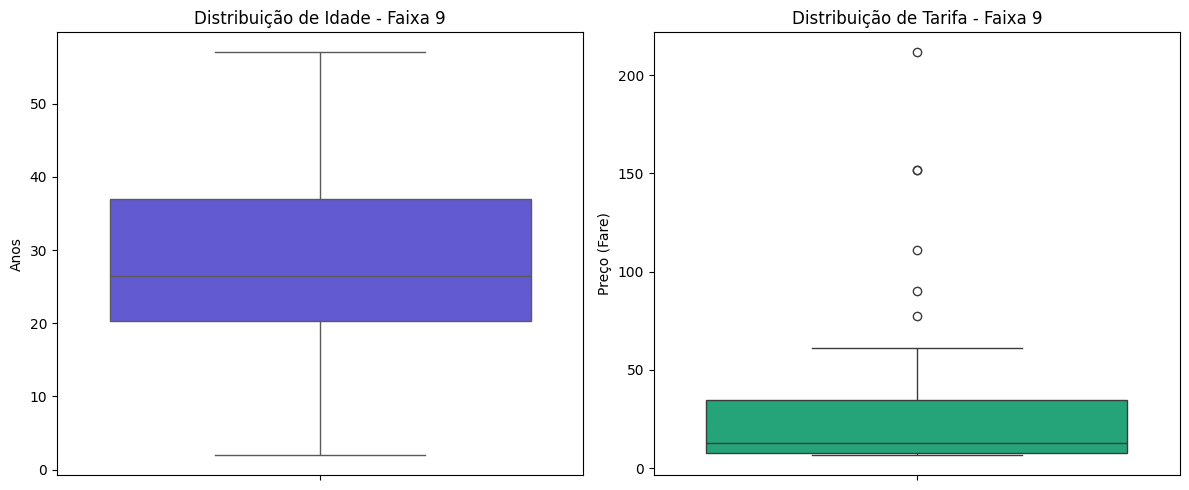

In [122]:
import pandas as pd


df_teste = df[df["Survived"] == 0].copy()
print(df_teste.head())


# 1. Obter as probabilidades e criar os decis no dataset de teste
probs = predictor.predict_proba(df_teste)[1]
test_data_with_scores = df_teste.copy()
test_data_with_scores["Score"] = probs
test_data_with_scores["Decil"] = pd.qcut(
    test_data_with_scores["Score"], 10, labels=False, duplicates="drop"
)

faixa = 9

# 2. Filtrar apenas os passageiros da Faixa 9 (Top 10%)
faixa_9 = test_data_with_scores[test_data_with_scores["Decil"] == faixa]

# 3. Gerar o Perfil Médio
print(f"--- Perfil dos Passageiros na Faixa {faixa} (N={len(faixa_9)}) ---")

# Estatísticas para colunas categóricas (o que é mais comum)
print("\nDistribuição de Sexo:")
print(faixa_9["Sex"].value_counts(normalize=True).map("{:.1%}".format))

print("\nDistribuição de Classe (Pclass):")
print(faixa_9["Pclass"].value_counts(normalize=True).sort_index().map("{:.1%}".format))

print("\nCidade de Embarque (Embarked):")
print(faixa_9["Embarked"].value_counts(normalize=True).map("{:.1%}".format))

# Estatísticas para colunas numéricas
print("\nMédias de Idade e Tarifa:")
print(faixa_9[["Age", "Fare"]].mean())

# 4. Bónus: Ver os "Top 5" passageiros com maior score
print("\n--- Top 5 Passageiros com maior probabilidade de sobrevivência ---")
cols_view = ["Sex", "Age", "Pclass", "Fare", "Score", "Survived"]

print(faixa_9[cols_view].sort_values(by="Score", ascending=False).head())

# 1. Filtrar a faixa desejada (ex: Faixa 9)
faixa_alvo = faixa
df_faixa = test_data_with_scores[test_data_with_scores["Decil"] == faixa_alvo]

# 2. Estatísticas Descritivas (Trazendo Q1 e Q3)
print(f"--- Estatísticas de Dispersão - Faixa {faixa_alvo} ---")
estatisticas = df_faixa[["Age", "Fare"]].describe(percentiles=[0.25, 0.5, 0.75])
print(estatisticas.loc[["25%", "50%", "75%"]])  # Traz Q1, Mediana e Q3

# 3. Plotagem dos Boxplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Boxplot para Idade
sns.boxplot(y=df_faixa["Age"], ax=axes[0], color="#4f46e5")
axes[0].set_title(f"Distribuição de Idade - Faixa {faixa_alvo}")
axes[0].set_ylabel("Anos")

# Boxplot para Tarifa (Fare)
sns.boxplot(y=df_faixa["Fare"], ax=axes[1], color="#10b981")
axes[1].set_title(f"Distribuição de Tarifa - Faixa {faixa_alvo}")
axes[1].set_ylabel("Preço (Fare)")

plt.tight_layout()
plt.show()

In [120]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

df_2 = test_data_with_scores.copy()

# 1. Seleção e Cópia
cols_float = df_2.select_dtypes(include=["float64", "float32"]).columns.tolist()

# 2. Criação dos Bins (Apenas o intervalo numérico)
for col in cols_float:
    if col == LABEL or col == "PassengerId":
        continue
    try:
        limites = df_2[col].quantile([0, 0.25, 0.5, 0.75, 1]).unique()
        bins_series = pd.cut(df_2[col], bins=limites, include_lowest=True)

        # Guardamos apenas o intervalo: [valor, valor]
        df_2[f"{col}_Bin"] = bins_series.apply(
            lambda x: f"[{x.left:.1f},{x.right:.1f}]"
        )
        print(f"Bins criados para: {col}")
    except Exception as e:
        print(f"Erro em {col}: {e}")


# 3. Função de Perfil com Prefixos Obrigatórios
def extrair_perfil_por_tfidf(df, decil_alvo, colunas_analise):
    df_copy = df.copy()

    for col in colunas_analise:
        # Forçamos o prefixo 'Coluna_' em todos os valores
        # O replace garante que o token não quebre em espaços
        df_copy[col] = col + "_" + df_copy[col].astype(str).str.replace(" ", "")

    # Transforma a linha em uma "frase" de atributos
    df_copy["perfil_txt"] = df_copy[colunas_analise].apply(
        lambda x: " ".join(x), axis=1
    )

    # Agrupa o "texto" por decil
    documentos_por_decil = df_copy.groupby("Decil")["perfil_txt"].apply(
        lambda x: " ".join(x)
    )
    decis_lista = documentos_por_decil.index.tolist()

    # Vetorizador que aceita caracteres especiais nos tokens (colchetes, vírgulas, etc)
    vectorizer = TfidfVectorizer(
        token_pattern=r"(?u)\b\w+[\(\)\[\],\.\d-]+\b|(?u)\b\w+\b"
    )
    tfidf_matrix = vectorizer.fit_transform(documentos_por_decil)
    feature_names = vectorizer.get_feature_names_out()

    idx_doc = decis_lista.index(decil_alvo)
    pesos = tfidf_matrix[idx_doc].toarray()[0]

    df_perfil = pd.DataFrame({"Atributo": feature_names, "Relevancia_TFIDF": pesos})
    return df_perfil.sort_values(by="Relevancia_TFIDF", ascending=False).head(10)


# --- EXECUÇÃO ---
colunas_para_perfil = ["Sex", "Pclass", "Embarked", "Age_Bin", "Fare_Bin"]

for i in range(0, 10):
    if i in df_2["Decil"].unique():
        perfil = extrair_perfil_por_tfidf(
            df_2, decil_alvo=i, colunas_analise=colunas_para_perfil
        )
        print(f"\n--- Top 10 Características Distintivas da Faixa {i} ---")
        print(perfil.to_string(index=False))  # Limpa o index para facilitar leitura
        print("-" * 50)

Bins criados para: Age
Bins criados para: Fare
Bins criados para: Score

--- Top 10 Características Distintivas da Faixa 0 ---
            Atributo  Relevancia_TFIDF
          embarked_s          0.526002
            sex_male          0.483922
            pclass_3          0.441842
fare_bin_[26.0,263.0          0.347161
   age_bin_[1.0,21.0          0.273521
 fare_bin_[10.5,26.0          0.168321
         age_bin_nan          0.136761
            pclass_2          0.136761
          sex_female          0.113680
  age_bin_[28.0,39.0          0.084160
--------------------------------------------------

--- Top 10 Características Distintivas da Faixa 1 ---
           Atributo  Relevancia_TFIDF
         embarked_s          0.584353
           sex_male          0.476139
           pclass_3          0.346283
fare_bin_[10.5,26.0          0.281355
           pclass_2          0.270534
 age_bin_[21.0,28.0          0.194784
         sex_female          0.168907
 age_bin_[39.0,74.0          0.151

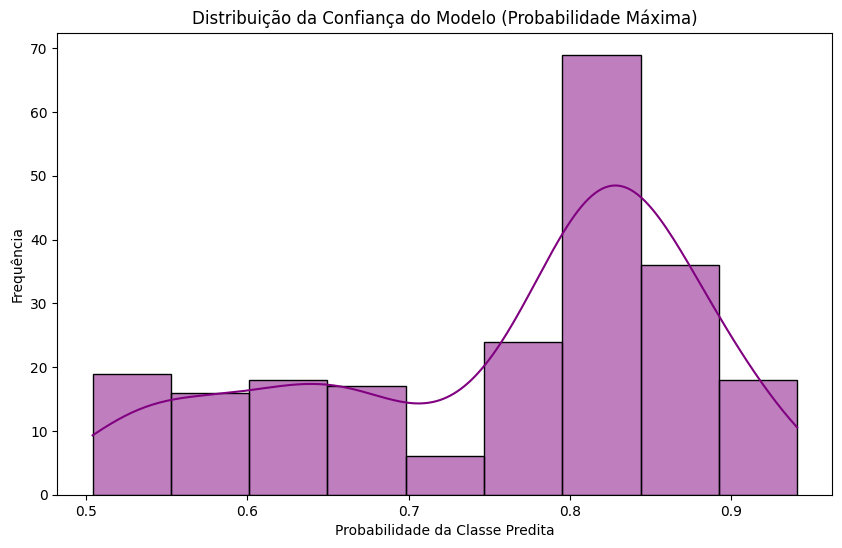

In [55]:
import seaborn as sns

# Pega as probabilidades de cada classe
y_prob = predictor.predict_proba(test_data)

# Vamos ver a distribuição da probabilidade da classe que o modelo escolheu
confianca_maxima = y_prob.max(axis=1)

plt.figure(figsize=(10, 6))
sns.histplot(confianca_maxima, kde=True, color="purple")
plt.title("Distribuição da Confiança do Modelo (Probabilidade Máxima)")
plt.xlabel("Probabilidade da Classe Predita")
plt.ylabel("Frequência")
plt.show()

In [ ]:
# Considerando que dos atributos utilizados, "raça/etnia" seja a mais relevante,
# foi optado que o dataset no momento do split fosse estratificado nessa categoria
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=X["race_encoded"], test_size=0.25, random_state=42
)

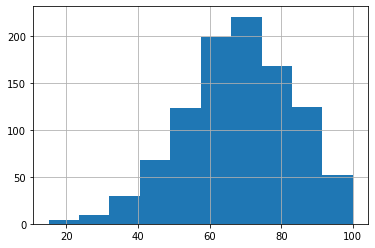

In [ ]:
# Distribuição das notas
y.hist()

In [ ]:
math_pred = TPOTRegressor(
    population_size=50, cv=5, max_eval_time_mins=0.2, max_time_mins=10, verbosity=2
)

## Toda as informações das gerações ao longo dos treinamentos é disponibilizada pelo *TPOT*, fazendo que seja acompanhável toda a evolução do desempenho dos modelos treinados pelo algoritmo

In [ ]:
math_pred.fit(X_train, y_train)

Optimization Progress:   0%|          | 0/50 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -178.20817045812421

Generation 2 - Current best internal CV score: -176.53092745818913

Generation 3 - Current best internal CV score: -175.42451117542433

Generation 4 - Current best internal CV score: -175.42451117542433

Generation 5 - Current best internal CV score: -175.42451117542433

Generation 6 - Current best internal CV score: -175.42451117542433

Generation 7 - Current best internal CV score: -175.3079281466673

Generation 8 - Current best internal CV score: -175.3079281466673

Generation 9 - Current best internal CV score: -175.3079281466673

Generation 10 - Current best internal CV score: -175.0112285713676

Generation 11 - Current best internal CV score: -175.0112285713676

Generation 12 - Current best internal CV score: -175.0112285713676

Generation 13 - Current best internal CV score: -174.76556937117556

Generation 14 - Current best internal CV score: -174.76556937117556

Generation 15 - Current best internal CV score: 

TPOTRegressor(max_eval_time_mins=0.2, max_time_mins=10, population_size=50,
              verbosity=2)

In [ ]:
# Score do dataset de teste
math_pred.score(X_test, y_test)

-151.82595885927367

In [ ]:
# Pipeline final do modelo com as normalizações e o algoritmo escolhido
math_pred.fitted_pipeline_

Pipeline(steps=[('normalizer', Normalizer(norm='max')),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(alpha=0.75, max_depth=1,
                                           max_features=0.5, min_samples_leaf=9,
                                           min_samples_split=19,
                                           subsample=0.8))])

In [ ]:
math_pred.export("tpot_mathprev.py")

### Para ilustrar, abaixo apenas o arquivo que é exportado do modelo treinado
Arquivo exportado: `tpot_mathprev.py`

Todas as bibliotecas necessárias caso o modelo precise ser utilizado de forma externa, junto dos metodos de pipeline e os parâmetros do modelo escolhido, que no caso foi o de `GradientBoostingRegressor`.

In [ ]:
"""import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'], random_state=None)

# Average CV score on the training set was: -174.08863987846144
exported_pipeline = make_pipeline(
    Normalizer(norm="max"),
    GradientBoostingRegressor(alpha=0.75, learning_rate=0.1, loss="ls", max_depth=1, max_features=0.5, min_samples_leaf=9, min_samples_split=19, n_estimators=100, subsample=0.8)
)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)"""

'import numpy as np\nimport pandas as pd\nfrom sklearn.ensemble import GradientBoostingRegressor\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.pipeline import make_pipeline\nfrom sklearn.preprocessing import Normalizer\n\n# NOTE: Make sure that the outcome column is labeled \'target\' in the data file\ntpot_data = pd.read_csv(\'PATH/TO/DATA/FILE\', sep=\'COLUMN_SEPARATOR\', dtype=np.float64)\nfeatures = tpot_data.drop(\'target\', axis=1)\ntraining_features, testing_features, training_target, testing_target =             train_test_split(features, tpot_data[\'target\'], random_state=None)\n\n# Average CV score on the training set was: -174.08863987846144\nexported_pipeline = make_pipeline(\n    Normalizer(norm="max"),\n    GradientBoostingRegressor(alpha=0.75, learning_rate=0.1, loss="ls", max_depth=1, max_features=0.5, min_samples_leaf=9, min_samples_split=19, n_estimators=100, subsample=0.8)\n)\n\nexported_pipeline.fit(training_features, training_target)\nresults

In [ ]:
y_pred = math_pred.predict(X_test)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# Calculo do MSE para o primeiro modelo
mse_1 = mean_squared_error(y_test, y_pred)

C:\Users\ggcs1\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


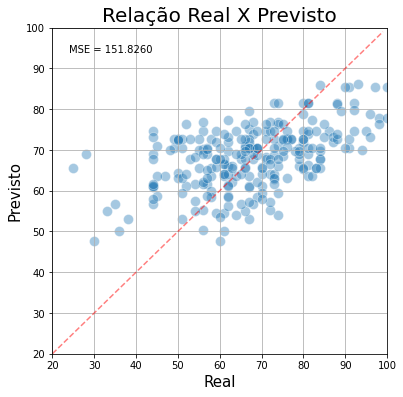

In [ ]:
plt.figure(figsize=(6, 6))
plt.title("Relação Real X Previsto", fontsize=20)
sns.scatterplot(y_test, y_pred, alpha=0.4, s=100)

linha_x = np.arange(100)
linha_y = linha_x
plt.plot(linha_x, linha_y, "r--", alpha=0.5)

plt.xlim((20, 100))
plt.ylim((20, 100))

plt.xlabel("Real", fontsize=15)
plt.ylabel("Previsto", fontsize=15)
plt.text(
    0.05, 0.95, f"MSE = {mse_1:.4f}", transform=plt.gca().transAxes, ha="left", va="top"
)
plt.grid()

In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

In [ ]:
# Instanciando o modelo
modelo = SGDRegressor()

In [ ]:
parametros = {
    "alpha": uniform(0.0001, 1),
    "penalty": ["l1", "l2", "elasticnet"],
    "l1_ratio": uniform(0, 1),
}

math_rscv = RandomizedSearchCV(modelo, param_distributions=parametros, n_iter=100)

In [ ]:
math_rscv.fit(X_train, y_train)
print(math_rscv.best_params_)

{'alpha': 0.04151876390860555, 'l1_ratio': 0.8241945837370115, 'penalty': 'l1'}


In [ ]:
best_model = math_rscv.best_estimator_
y_rscv = best_model.predict(X_test)

In [ ]:
# Calculo do MSE para o segundo modelo
mse_2 = mean_squared_error(y_test, y_rscv)

C:\Users\ggcs1\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


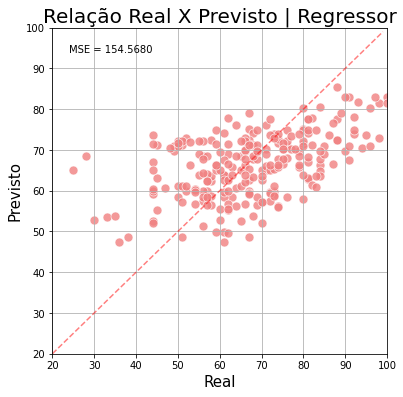

In [ ]:
plt.figure(figsize=(6, 6))
plt.title("Relação Real X Previsto | Regressor", fontsize=20)
sns.scatterplot(y_test, y_rscv, alpha=0.8, s=80, color="lightcoral")
# sns.scatterplot(y_test, y_pred, alpha=0.4, s=80)

linha_x = np.arange(100)
linha_y = linha_x
plt.plot(linha_x, linha_y, "r--", alpha=0.5)

plt.xlim((20, 100))
plt.ylim((20, 100))

plt.xlabel("Real", fontsize=15)
plt.ylabel("Previsto", fontsize=15)
plt.text(
    0.05, 0.95, f"MSE = {mse_2:.4f}", transform=plt.gca().transAxes, ha="left", va="top"
)
plt.grid()

## Considerações finais

É possível concluir que ambos os modelos se comportam de maneira semelhante em relação aos seus resultados, principalmente ao se observar as visualizações disponíveis, nas quais a distribuição dos datapoints dos dois modelos permanece em lugares similares. A diferença entre os modelos é evidenciada pela pontuação de cada um no Mean Squared Error (MSE), que foi utilizado nesse teste por penalizar os valores mais extremos.

O modelo treinado pelo TPOT obteve uma pontuação de `151,82`, enquanto o modelo SGDRegressor obteve `154,56`. Portanto, o modelo gerado pelo TPOT obteve uma pontuação melhor, já que quanto menor o valor do MSE, mais ajustado o modelo está.

É importante destacar que embora a biblioteca seja uma ferramenta poderosa para automatizar a seleção de modelos e hiperparâmetros, é necessário avaliar cuidadosamente os resultados obtidos e realizar mais testes em diferentes conjuntos de dados antes de considerar o modelo final como um sucesso. Ainda é preciso verificar se o modelo é capaz de generalizar bem para novos dados e se é robusto o suficiente para lidar com diferentes cenários e variações nos dados. Mais testes precisam ser realizados para comprovar a eficácia da biblioteca em diferentes situações e tarefas de aprendizado de máquina.

Apesar da facilidade que o TPOT pode oferecer como um assistente de automação de machine learning, é importante lembrar que seu uso não deve substituir completamente os métodos tradicionais de treinamento. Os métodos tradicionais fornecem insights de investigação sobre os dados, permitindo uma melhor compreensão de como cada modelo de machine learning funciona em teoria. Portanto, o TPOT deve ser utilizado por profissionais experientes na área, que saibam avaliar e projetar seus projetos de maneira cuidadosa, e que utilizem o TPOT para automatizar tarefas que já dominam, funcionando de fato como um assistente.